In [1]:
import sys
sys.path.append('../../')

In [2]:
from codes.docs.analysis import graph_analysis, data_preprocessing

import numpy as np
from sklearn.preprocessing import StandardScaler

## Examining structural connectivity in neonates at genetic risk for schizophrenia

According to this [paper](https://www.sciencedirect.com/science/article/pii/S1053811912005149?via%3Dihub), there is some difference in the network measure properties between high risk and low risk neonates.

Here, I applied similar analysis to the high/low risk to see if we can reach similar conclusion

Upon computing the inter-regional GM structural associations and WM fiber connections, we constructed morphological networks and white matter networks for both high-risk and low-risk neonates. Graph-theoretic network analysis was then applied for analysis of these networks to determine between group differences. Network property metrics such as **clustering coefficient, path length, network efficiency, small- worldness, and centrality** were computed for comparison purposes.

* ***clustering coefficient***= measures the whole brain segregation, is the average of the absolute clustering coefficient of all nodes.
* ***shortest absolute path length***= measures the whole brain functional integration, is the average of the shortest absolute path lengths between the nodes.
* ***Small world network*** has a similar absolute path lengths but higher absolute clustering coefficients than those of random networks with the same number of nodes and edges, which can be represented by the two parameters, namely normalized clustering and normalized path length.

Statistical analysis used in the paper: 
A non-parametric permutation test was employed to assess the statistical difference of brain network properties between two groups. First a network property measure was computed separately for two groups of neonates. Then they randomly assigned the regional cortical of each subject to either group. Corr matrix was recomputed for each of the 2 randomized groups, and a new value for the network property was measure and obtained. This procedure was repeated 1000 times and signifiance is reached if less than 5% of between group difference in the permutation distribution was greater than the observed group difference. This procedure was repeated for each sparsity threshold

Here I use only the GM structural information, 52 variables. Absolute values of the correlations were taken as indicators of connections. 

In [3]:
# importing the preprocessed data
adjusted_european_GM_structural_schizophrenia=np.load('./preprocessed_data/adjusted_european_GM_structural_schizophrenia.npy')
structural_GM_labels=np.load('./preprocessed_data/structural_GM_labels.npy',allow_pickle=True)
european_prs_schizophrenia=np.load('./preprocessed_data/european_prs_schizophrenia.npy',allow_pickle=True)

In [4]:
#Dividing the data set into high and low risk
#get the indices of the low and high risk
low_risk,high_risk=data_preprocessing.high_low_risk_divide(european_prs_schizophrenia[:,5],bins=100,percentage=0.3)
X_low_risk=adjusted_european_GM_structural_schizophrenia[low_risk,:]
X_high_risk=adjusted_european_GM_structural_schizophrenia[high_risk,:]
X=np.vstack((X_low_risk,X_high_risk))
X=StandardScaler().fit_transform(X)
y=np.concatenate((np.zeros(X_low_risk.shape[0]),np.ones(X_high_risk.shape[0])))

In [5]:
#rearrange the matrix by side
right_indices=np.array([idx for idx,i in enumerate(structural_GM_labels) if 'right' in i])
print(right_indices.shape)
left_indices=np.array([idx for idx,i in enumerate(structural_GM_labels) if 'left' in i])
print(left_indices.shape)
neither_indices=np.array([idx for idx,i in enumerate(structural_GM_labels) if 'right' not in i and 'left' not in i])
rearrange_by_side_indices=np.concatenate((right_indices,left_indices,neither_indices),axis=0)

(25,)
(25,)


In [270]:
corrmatrix_low_risk=abs(np.corrcoef(X[y==0,:],rowvar=False))
np.fill_diagonal(corrmatrix_low_risk,0)
corrmatrix_high_risk=abs(np.corrcoef(X[y==1,:],rowvar=False))
np.fill_diagonal(corrmatrix_high_risk,0)

In [271]:
rearranged_corrmatrix_low_risk=np.asarray([[corrmatrix_low_risk[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

rearranged_corrmatrix_high_risk=np.asarray([[corrmatrix_high_risk[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

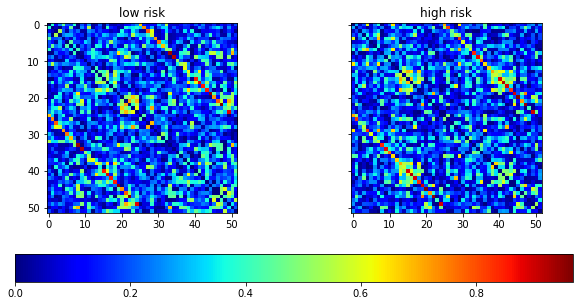

In [272]:
f,(ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(10,5))
im=ax1.imshow(rearranged_corrmatrix_low_risk,cmap='jet')
ax1.set_title('low risk')
im=ax2.imshow(rearranged_corrmatrix_high_risk,cmap='jet')
ax2.set_title('high risk')
f.colorbar(im,ax=[ax1,ax2],orientation='horizontal')

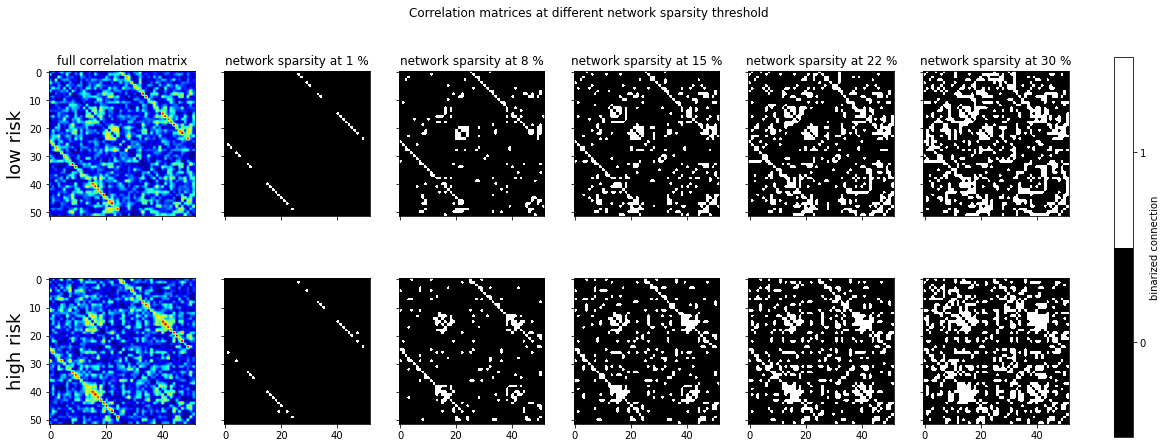

In [44]:
f,axes=plt.subplots(2,6,sharex=True,sharey=True,figsize=(20,7))
network_sparsity_threshold=[int(i) for i in (np.linspace(1,30,5))]
for idx,ax in enumerate(axes[0]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_low_risk,cmap='jet')
        ax.set_title('full correlation matrix')
        ax.set_ylabel('low risk',fontsize=18)
    else:
        binarized_matrix=preprocessing.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_low_risk,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        ax.set_title('network sparsity at %d %%'%(len(np.where(preprocessing.lower_triangle(binarized_matrix,52)==1)[0])*100/(52*51/2)))
        im.set_clim(-0.5,1.5)
for idx,ax in enumerate(axes[1]):
    if idx==0:
        im=ax.imshow(rearranged_corrmatrix_high_risk,cmap='jet')
        ax.set_ylabel('high risk',fontsize=18)
    else:
        binarized_matrix=preprocessing.binarize_matrix_based_on_sparsity_threshold(rearranged_corrmatrix_high_risk,network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        im.set_clim(-0.5,1.5)

f.suptitle('Correlation matrices at different network sparsity threshold')
f.colorbar(im,ax=np.concatenate(axes),ticks=range(2),label='binarized connection',fraction=0.046, pad=0.04)

In [273]:
binarized_low_risk_matrices=np.asarray([preprocessing.lower_triangle(preprocessing.binarize_matrix_based_on_sparsity_threshold(corrmatrix_low_risk,network_sparsity_threshold/100,bins=100),52) for network_sparsity_threshold in np.linspace(1,30,30)])
binarized_high_risk_matrices=np.asarray([preprocessing.lower_triangle(preprocessing.binarize_matrix_based_on_sparsity_threshold(corrmatrix_high_risk,network_sparsity_threshold/100,bins=100),52) for network_sparsity_threshold in np.linspace(1,30,30)])

In [274]:
structural_GM_combinations=[]
ROIs=np.arange(len(structural_GM_labels))
for i in ROIs:
    structural_GM_combination=[str(i)+'_'+str(n) for n in ROIs]
    structural_GM_combinations.append(structural_GM_combination)
structural_GM_combinations=np.vstack(structural_GM_combinations)
structural_GM_combinations=preprocessing.lower_triangle(structural_GM_combinations,52)

In [20]:
structural_GM_combinations[binarized_low_risk_matrices[0,:]==1]

array(['3_2', '5_4', '9_8', '11_10', '17_16', '20_19', '32_31', '34_33',
       '36_35', '38_37', '40_39', '42_41', '44_43', '46_45', '51_50'],
      dtype='<U5')

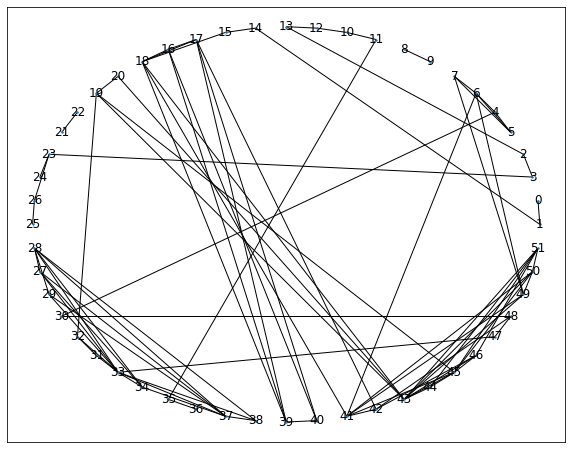

In [23]:
import networkx as nx
plt.figure(figsize=(10,8))
test=preprocessing.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in structural_GM_combinations[binarized_low_risk_matrices[5,:]==1]])
pos=nx.circular_layout(test)
nx.draw_networkx(test,pos,node_size=2)
plt.show()

## Global and Local Efficiency

### Structural dataset

In [78]:
from networkx.algorithms.efficiency_measures import global_efficiency,local_efficiency

In [79]:
import time
import networkx as nx
starttime=time.time()
low_risk_metrics={'global_efficiency':[],'local_efficiency':[]}
high_risk_metrics={'global_efficiency':[],'local_efficiency':[]}

for n in range(30):#30 sparsity thresholds
    temp_low_risk_graph=preprocessing.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in structural_GM_combinations[binarized_low_risk_matrices[n,:]==1]])

    temp_high_risk_graph=preprocessing.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in structural_GM_combinations[binarized_high_risk_matrices[n,:]==1]])

    low_risk_metrics['global_efficiency'].append(global_efficiency(temp_low_risk_graph))
    high_risk_metrics['global_efficiency'].append(global_efficiency(temp_high_risk_graph))

    low_risk_metrics['local_efficiency'].append(local_efficiency(temp_low_risk_graph))
    high_risk_metrics['local_efficiency'].append(local_efficiency(temp_high_risk_graph))

print(time.time()-starttime)

4.208697080612183


In [155]:
"""Takes long time to run, don't run it again"""
from more_itertools import random_permutation
import time

starttime=time.time()

random_low_risk_graphs=[]
random_high_risk_graphs=[]

binarized_random_low_matrices_all_perm=[]
binarized_random_high_matrices_all_perm=[]

for perm_run in range(1000):
    new_indices=random_permutation(np.arange(X.shape[0]),X.shape[0]) # we generate new set of indices.
    new_y=np.where(np.asarray(new_indices)>=X_low_risk.shape[0],1,0)#we will then assign the original sample based on the target y.

    corrmatrix_random_low_risk=abs(np.corrcoef(X[new_y==0,:],rowvar=False))
    np.fill_diagonal(corrmatrix_random_low_risk,0)
    corrmatrix_random_high_risk=abs(np.corrcoef(X[new_y==1,:],rowvar=False))
    np.fill_diagonal(corrmatrix_random_high_risk,0)

    binarized_random_low_risk_matrices=np.asarray([preprocessing.lower_triangle(binarize_matrix_based_on_sparsity_threshold(corrmatrix_random_low_risk,network_sparsity_threshold/100,bins=100),52) for network_sparsity_threshold in np.linspace(1,30,30)])

    binarized_random_high_risk_matrices=np.asarray([preprocessing.lower_triangle(binarize_matrix_based_on_sparsity_threshold(corrmatrix_random_high_risk,network_sparsity_threshold/100,bins=100),52) for network_sparsity_threshold in np.linspace(1,30,30)])

    binarized_random_low_matrices_all_perm.append(binarized_random_low_risk_matrices)
    binarized_random_high_matrices_all_perm.append(binarized_random_high_risk_matrices)

    temp_random_low_risk_graphs=[]
    temp_random_high_risk_graphs=[]

    for n in range(30):

        temp_random_low_risk_graph=visualisation.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in structural_GM_combinations[binarized_random_low_risk_matrices[n,:]==1]])

        temp_random_high_risk_graph=visualisation.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in structural_GM_combinations[binarized_random_high_risk_matrices[n,:]==1]])
        
        temp_random_low_risk_graphs.append(temp_random_low_risk_graph)
        temp_random_high_risk_graphs.append(temp_random_high_risk_graph)
    
    random_low_risk_graphs.append(temp_random_low_risk_graphs)
    random_high_risk_graphs.append(temp_random_high_risk_graphs)


print(time.time()-starttime)


226.07104015350342


In [212]:
"""the outputs are saved here"""
# np.save('./randomized_graph/binarized_random_low_matrices_all_perm.npy',np.asarray(binarized_random_low_matrices_all_perm))
# np.save('./randomized_graph/binarized_random_high_matrices_all_perm.npy',np.asarray(binarized_random_high_matrices_all_perm))
# save_the_object(random_low_risk_graphs,'./randomized_graph/random_low_risk_graphs.pkl')
# save_the_object(random_high_risk_graphs,'./randomized_graph/random_high_risk_graphs.pkl')

In [167]:
"""don't run this use the randomized_graph_score_calc.py to run remotely"""
# #calculate_the_scores from the graphs objects
# starttime=time.time()
# random_low_risk_graph_metrics={'global_efficiency':{},'local_efficiency':{}}
# random_high_risk_graph_metrics={'global_efficiency':{},'local_efficiency':{}}

# for i in range(10):
#     random_low_risk_graph_metrics['global_efficiency'][i]=[global_efficiency(n) for n in random_low_risk_graphs[i]]
#     random_high_risk_graph_metrics['global_efficiency'][i]=[global_efficiency(n) for n in random_high_risk_graphs[i]]

#     random_low_risk_graph_metrics['local_efficiency'][i]=[local_efficiency(n) for n in random_low_risk_graphs[i]]
#     random_high_risk_graph_metrics['local_efficiency'][i]=[local_efficiency(n) for n in random_high_risk_graphs[i]]

# print(time.time()-starttime)

24.684294939041138


In [221]:
# load the outputs here
random_high_risk_graph_metrics0300=load_the_object('./randomized_graph/random_high_risk_graph_metrics0300.pkl')
random_low_risk_graph_metrics0300=load_the_object('./randomized_graph/random_low_risk_graph_metrics0300.pkl')

random_high_risk_graph_metrics300600=load_the_object('./randomized_graph/random_high_risk_graph_metrics300600.pkl')
random_low_risk_graph_metrics300600=load_the_object('./randomized_graph/random_low_risk_graph_metrics300600.pkl')

random_high_risk_graph_metrics6001000=load_the_object('./randomized_graph/random_high_risk_graph_metrics6001000.pkl')
random_low_risk_graph_metrics6001000=load_the_object('./randomized_graph/random_low_risk_graph_metrics6001000.pkl')

In [245]:
random_high_risk_graph_metrics={'global_efficiency':{},'local_efficiency':{}}

random_high_risk_graph_metrics['global_efficiency']={**random_high_risk_graph_metrics0300['global_efficiency'],**random_high_risk_graph_metrics300600['global_efficiency'],**random_high_risk_graph_metrics6001000['global_efficiency']}
random_high_risk_graph_metrics['local_efficiency']={**random_high_risk_graph_metrics0300['local_efficiency'],**random_high_risk_graph_metrics300600['local_efficiency'],**random_high_risk_graph_metrics6001000['local_efficiency']}

random_low_risk_graph_metrics={'global_efficiency':{},'local_efficiency':{}}
random_low_risk_graph_metrics['global_efficiency']={**random_low_risk_graph_metrics0300['global_efficiency'],**random_low_risk_graph_metrics300600['global_efficiency'],**random_low_risk_graph_metrics6001000['global_efficiency']}
random_low_risk_graph_metrics['local_efficiency']={**random_low_risk_graph_metrics0300['local_efficiency'],**random_low_risk_graph_metrics300600['local_efficiency'],**random_low_risk_graph_metrics6001000['local_efficiency']}

In [248]:
random_difference={'global_efficiency':{},'local_efficiency':{}}
for i in range(1000):
    random_difference['global_efficiency'][i]=np.asarray(random_high_risk_graph_metrics['global_efficiency'][i])-np.asarray(random_low_risk_graph_metrics['global_efficiency'][i])

    random_difference['local_efficiency'][i]=np.asarray(random_high_risk_graph_metrics['local_efficiency'][i])-np.asarray(random_low_risk_graph_metrics['local_efficiency'][i])

check for significance difference, it is reached if less than 5 percentile of between-group difference in the permutation distribution was greater than the observed group difference.

Here, I performed two-tailed test taking the absolute difference. 

(array([  1.,   3.,   8.,  20.,  63., 222., 377., 229.,  57.,  20.]),
 array([-0.05506823, -0.04667536, -0.0382825 , -0.02988964, -0.02149678,
        -0.01310391, -0.00471105,  0.00368181,  0.01207467,  0.02046754,
         0.0288604 ]),
 <a list of 10 Patch objects>)

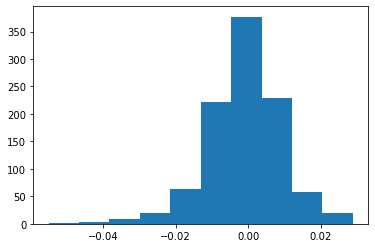

In [343]:
plt.hist([random_difference['global_efficiency'][i][0] for i in range(1000)])

In [338]:
p_values_perm_global_eff=[]
for n in range(30):
    observed_group_diff=abs(high_risk_metrics['global_efficiency'][n]-low_risk_metrics['global_efficiency'][n])
    random_group_diff=[abs(random_difference['global_efficiency'][i][n]) for i in range(1000)]
    temp_p_value=len(np.where(np.asarray(random_group_diff)>=observed_group_diff)[0])/1000
    p_values_perm_global_eff.append(temp_p_value)

p_values_perm_local_eff=[]
for n in range(30):
    observed_group_diff=abs(high_risk_metrics['local_efficiency'][n]-low_risk_metrics['local_efficiency'][n])
    random_group_diff=[abs(random_difference['local_efficiency'][i][n]) for i in range(1000)]
    temp_p_value=len(np.where(np.asarray(random_group_diff)>=observed_group_diff)[0])/1000
    p_values_perm_local_eff.append(temp_p_value)

In [341]:
significant_indices_global_eff=[idx for idx,i in enumerate(p_values_perm_global_eff) if i <=0.025]
significant_indices_local_eff=[idx for idx,i in enumerate(p_values_perm_local_eff) if i <=0.025]

Text(0.5, 1.0, 'global efficiency')

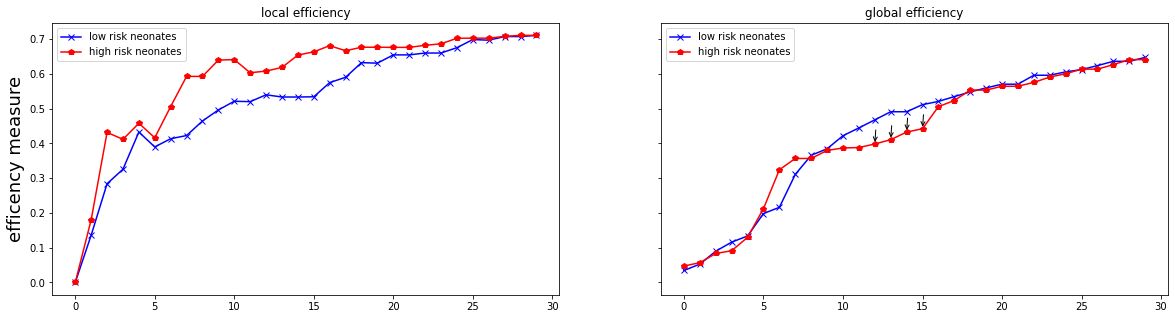

In [342]:
f,(ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(20,5))
ax1.plot(low_risk_metrics['local_efficiency'],'x-',color='blue',label='low risk neonates')
ax1.plot(high_risk_metrics['local_efficiency'],'p-',color='red',label='high risk neonates')
for idx in significant_indices_local_eff:
    ax1.annotate(' ',xy=(idx,high_risk_metrics['local_efficiency'][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
ax1.legend(loc='bottom right')
ax1.set_title('local efficiency')
ax1.set_ylabel('efficency measure',fontsize=18)

ax2.plot(low_risk_metrics['global_efficiency'],'x-',color='blue',label='low risk neonates')
ax2.plot(high_risk_metrics['global_efficiency'],'p-',color='red',label='high risk neonates')
for idx in significant_indices_global_eff:
    ax2.annotate(' ',xy=(idx,high_risk_metrics['global_efficiency'][idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
ax2.legend(loc='bottom right')
ax2.set_title('global efficiency')

which nodes are driving this differences?

we can do so by comparing the binarized matrices between the two groups as well examining the network between them.

In [275]:
binarized_low_risk_matrix_at_15=preprocessing.binarize_matrix_based_on_sparsity_threshold(corrmatrix_low_risk,.15,bins=100)
binarized_high_risk_matrix_at_15=preprocessing.binarize_matrix_based_on_sparsity_threshold(corrmatrix_high_risk,.15,bins=100)

In [276]:
from random import choices
starttime=time.time()

binarized_random_low_matrices_all_perm=[]
binarized_random_high_matrices_all_perm=[]

for perm_run in range(1000):
    new_y=np.asarray(choices([0,1],k=X.shape[0]))
    corrmatrix_random_low_risk=abs(np.corrcoef(X[new_y==0,:],rowvar=False))
    np.fill_diagonal(corrmatrix_random_low_risk,0)
    corrmatrix_random_high_risk=abs(np.corrcoef(X[new_y==1,:],rowvar=False))
    np.fill_diagonal(corrmatrix_random_high_risk,0)

    binarized_random_low_risk_matrix=np.asarray([preprocessing.lower_triangle(preprocessing.binarize_matrix_based_on_sparsity_threshold(corrmatrix_random_low_risk,.15,bins=100),52)])

    binarized_random_high_risk_matrix=np.asarray([preprocessing.lower_triangle(preprocessing.binarize_matrix_based_on_sparsity_threshold(corrmatrix_random_high_risk,.15,bins=100),52)])

    binarized_random_low_matrices_all_perm.append(binarized_random_low_risk_matrix)
    binarized_random_high_matrices_all_perm.append(binarized_random_high_risk_matrix)

print(time.time()-starttime)

3.6600048542022705


In [277]:
binarized_random_low_matrices_all_perm=np.concatenate(binarized_random_low_matrices_all_perm)
binarized_random_high_matrices_all_perm=np.concatenate(binarized_random_high_matrices_all_perm)

In [278]:
binarized_random_differences_at_15=binarized_random_high_matrices_all_perm-binarized_random_low_matrices_all_perm

In [279]:
binarized_low_risk_matrix_at_15=preprocessing.lower_triangle(binarized_low_risk_matrix_at_15,52)
binarized_high_risk_matrix_at_15=preprocessing.lower_triangle(binarized_high_risk_matrix_at_15,52)

In [280]:
binarized_differences_at_15=binarized_high_risk_matrix_at_15-binarized_low_risk_matrix_at_15

In [281]:
p_values=[]
for i in range(binarized_differences_at_15.shape[0]):
    temp_p_value=len(np.where(abs(binarized_random_differences_at_15[:,i])==abs(binarized_differences_at_15[i]))[0])/1000
    p_values.append(temp_p_value)


In [407]:
[(idx,i*1326) for idx,i in enumerate(p_values) if i <=0.025]

[(808, 9.282), (2427, 25.194), (2920, 13.26)]

In [406]:
binarized_differences_at_15.shape[0]

1326

In [283]:
print(structural_GM_combinations[298],structural_GM_combinations[502],structural_GM_combinations[568])

24_22 32_6 34_7


In [284]:
print('+'.join([structural_GM_labels[24],structural_GM_labels[22]]))
print('+'.join([structural_GM_labels[32],structural_GM_labels[6]]))
print('+'.join([structural_GM_labels[34],structural_GM_labels[7]]))

Gyri parahippocampalis et ambiens posterior part left GM+Occipital lobe left GM
Cingulate gyrus, anterior part left GM+Anterior temporal lobe, lateral part left GM
Cingulate gyrus, posterior part left GM+Anterior temporal lobe, lateral part right GM


The paper also found that high-risk neonates have significantly lower global efficiency and higher local efficiency.

### diffusion dataset

In [142]:
from networkx.algorithms.efficiency_measures import global_efficiency,local_efficiency

In [362]:
low_risk,high_risk=preprocessing.high_low_risk_divide(european_prs_schizophrenia[:,5],bins=100,percentage=0.3)
adjusted_european_connectivity_schizophrenia_with_zeros=preprocessing.adjusting_for_covariates_with_lin_reg(y=inputs_european_connectivity_matrices_schizophrenia,covariates=[european_age_at_scan,european_gestational_age,european_gender])
X_low_risk=adjusted_european_connectivity_schizophrenia_with_zeros[low_risk,:]
X_high_risk=adjusted_european_connectivity_schizophrenia_with_zeros[high_risk,:]
X=np.vstack((X_low_risk,X_high_risk))
X=StandardScaler().fit_transform(X)
X[:,features_to_be_removed]=0 #retain only the connectivity features that have been recorded in all subject. #removed 3268
y=np.concatenate((np.zeros(X_low_risk.shape[0]),np.ones(X_high_risk.shape[0])))

In [363]:
X_mean_connectivity_low_risk=np.mean(X[y==0],axis=0)
X_mean_connectivity_high_risk=np.mean(X[y==1],axis=0)

In [364]:
def reverse_lower_triangle(matrix, side_of_the_square=90):
    return_matrix=np.zeros((side_of_the_square,side_of_the_square))
    counter=0
    for i in range(1,side_of_the_square):
        for n in range(i):
            return_matrix[n][i]=return_matrix[i][n]=matrix[counter]
            counter+=1
    return return_matrix

In [365]:
connectivity_regions=([(str.split(i,'_'))[0] for i in ROIs_combinations[:,0]])
right_indices=np.array([idx for idx,i in enumerate(connectivity_regions) if '.R' in i])
print(right_indices.shape)
left_indices=np.array([idx for idx,i in enumerate(connectivity_regions) if '.L' in i])
print(left_indices.shape)
rearrange_by_side_indices=np.concatenate((right_indices,left_indices),axis=0)

(45,)
(45,)


In [366]:
X_mean_connectivity_low_risk=reverse_lower_triangle(X_mean_connectivity_low_risk)
X_mean_connectivity_high_risk=reverse_lower_triangle(X_mean_connectivity_high_risk)

In [367]:
rearranged_mean_connectivity_low_risk=np.asarray([[X_mean_connectivity_low_risk[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

rearranged_mean_connectivity_high_risk=np.asarray([[X_mean_connectivity_high_risk[i][j] for j in rearrange_by_side_indices] for i in rearrange_by_side_indices])

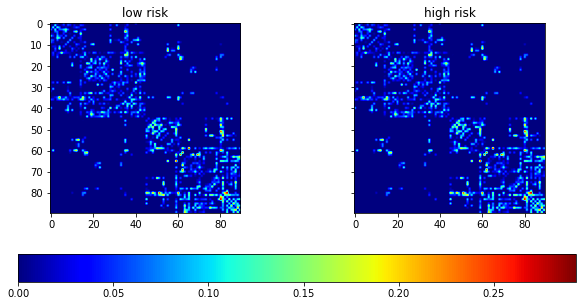

In [368]:
f,(ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(10,5))
im=ax1.imshow(abs(rearranged_mean_connectivity_low_risk),cmap='jet')
ax1.set_title('low risk')
im=ax2.imshow(abs(rearranged_mean_connectivity_high_risk),cmap='jet')
ax2.set_title('high risk')
f.colorbar(im,ax=[ax1,ax2],orientation='horizontal')

In [387]:
from random import choices
starttime=time.time()

connectivity_random_low_matrices_all_perm=[]
connectivity_random_high_matrices_all_perm=[]

for perm_run in range(1000):
    new_y=np.asarray(choices([0,1],k=X.shape[0]))
    connectivity_random_low_matrices_all_perm.append(np.mean(X[new_y==0],axis=0))
    connectivity_random_high_matrices_all_perm.append(np.mean(X[new_y==1],axis=0))
print(time.time()-starttime)

0.4926328659057617


In [388]:
connectivity_random_low_matrices_all_perm=np.vstack(connectivity_random_low_matrices_all_perm)
connectivity_random_high_matrices_all_perm=np.vstack(connectivity_random_high_matrices_all_perm)

In [389]:
connectivity_random_diff=connectivity_random_high_matrices_all_perm-connectivity_random_low_matrices_all_perm
connectivity_real_mean_diff=preprocessing.lower_triangle(X_mean_connectivity_high_risk-X_mean_connectivity_low_risk)

In [390]:
p_values=[]
for i in range(connectivity_random_diff.shape[1]):
    temp_p_value=len(np.where(abs(connectivity_random_diff[:,i])>=abs(connectivity_real_mean_diff[i]))[0])/1000
    p_values.append(temp_p_value)


In [391]:
[(connectivity_combinations[idx],i) for idx,i in enumerate(p_values) if i <=0.025]

[('AMYG.L_INS.L', 0.007), ('CAU.L_IFGtriang.L', 0.019), ('THA.L_CAU.L', 0.01)]

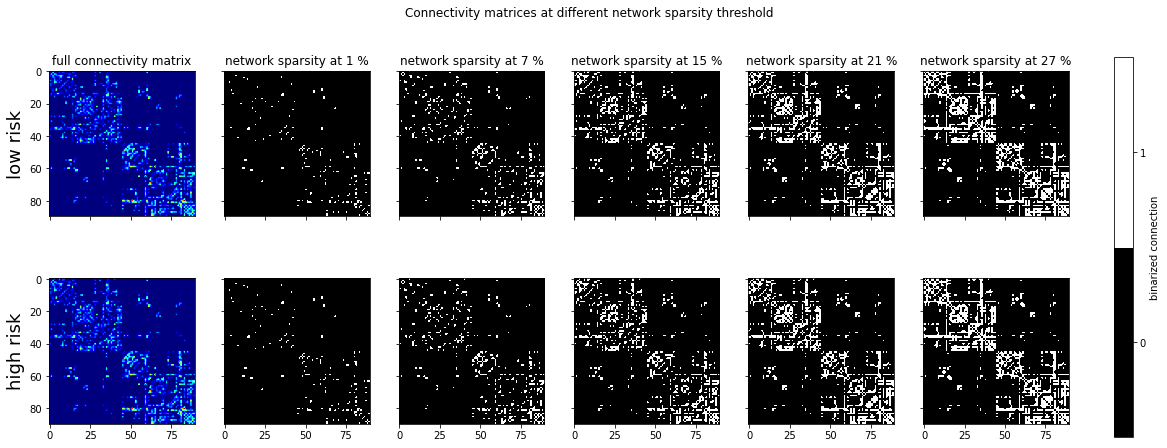

In [405]:
f,axes=plt.subplots(2,6,sharex=True,sharey=True,figsize=(20,7))
network_sparsity_threshold=[int(i) for i in (np.linspace(2,20,5))]
for idx,ax in enumerate(axes[0]):
    if idx==0:
        im=ax.imshow(abs(rearranged_mean_connectivity_low_risk),cmap='jet')
        ax.set_title('full connectivity matrix')
        ax.set_ylabel('low risk',fontsize=18)
    else:
        binarized_matrix=preprocessing.binarize_matrix_based_on_sparsity_threshold(abs(rearranged_mean_connectivity_low_risk),network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        ax.set_title('network sparsity at %d %%'%(len(np.where(preprocessing.lower_triangle(binarized_matrix,52)==1)[0])*100/(52*51/2)))
        im.set_clim(-0.5,1.5)
for idx,ax in enumerate(axes[1]):
    if idx==0:
        im=ax.imshow(abs(rearranged_mean_connectivity_high_risk),cmap='jet')
        ax.set_ylabel('high risk',fontsize=18)
    else:
        binarized_matrix=preprocessing.binarize_matrix_based_on_sparsity_threshold(abs(rearranged_mean_connectivity_high_risk),network_sparsity_threshold[idx-1]/100,bins=100)
        im=ax.imshow(binarized_matrix,cmap=plt.cm.get_cmap('cubehelix', 2))
        im.set_clim(-0.5,1.5)

f.suptitle('Connectivity matrices at different network sparsity threshold')
f.colorbar(im,ax=np.concatenate(axes),ticks=range(2),label='binarized connection',fraction=0.046, pad=0.04)

In [ ]:
import time
import networkx as nx
starttime=time.time()
low_risk_metrics={'global_efficiency':[],'local_efficiency':[]}
high_risk_metrics={'global_efficiency':[],'local_efficiency':[]}

for n in range(30):#30 sparsity thresholds
    temp_low_risk_graph=preprocessing.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in structural_GM_combinations[binarized_low_risk_matrices[n,:]==1]])

    temp_high_risk_graph=preprocessing.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in structural_GM_combinations[binarized_high_risk_matrices[n,:]==1]])

    low_risk_metrics['global_efficiency'].append(global_efficiency(temp_low_risk_graph))
    high_risk_metrics['global_efficiency'].append(global_efficiency(temp_high_risk_graph))

    low_risk_metrics['local_efficiency'].append(local_efficiency(temp_low_risk_graph))
    high_risk_metrics['local_efficiency'].append(local_efficiency(temp_high_risk_graph))

print(time.time()-starttime)

## Clustering coefficients, average shortest path length and small worldness

A small-world network has similar absolute path lengths but higher absolute clustering coefficients than those of random networks with the same number of nodes and edges, which can be represented by the two parameters, namely normalized clustering, gamma= Creal/Crand >1 and normalized path length = lambda= Lreal/Lrand. Those two parameters can be further summarized as small worldness- sigma=gamma/lambda.


In [24]:
import networkx as nx
from networkx.algorithms.cluster import clustering
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.exception import NetworkXError

In [25]:
test=preprocessing.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in structural_GM_combinations[binarized_low_risk_matrices[0,:]==1]])

In [255]:
import time
start=time.time()
C_rand_low_risk=[]
L_rand_low_risk=[]

for n in range(30):
    graph=preprocessing.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in structural_GM_combinations[binarized_low_risk_matrices[n,:]==1]])
    C_rand=[]
    L_rand=[]
    for i in range(1000):
        x=preprocessing.create_random_graph(graph,1000)
        clustering_values,path_length=preprocessing.clustering_coefficient_and_path_length(next(x))
        C_rand.append(clustering_values)
        L_rand.append(path_length)
    C_rand_low_risk.append(np.mean(C_rand))
    L_rand_low_risk.append(np.mean(L_rand))
print(time.time()-start)

C_rand_high_risk=[]
L_rand_high_risk=[]
###high-risk####

for n in range(30):
    graph=preprocessing.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in structural_GM_combinations[binarized_high_risk_matrices[n,:]==1]])
    C_rand=[]
    L_rand=[]
    for i in range(1000):
        x=preprocessing.create_random_graph(graph,1000)
        clustering_values,path_length=preprocessing.clustering_coefficient_and_path_length(next(x))
        C_rand.append(clustering_values)
        L_rand.append(path_length)
    C_rand_high_risk.append(np.mean(C_rand))
    L_rand_high_risk.append(np.mean(L_rand))
print(time.time()-start)

468.8047637939453
944.3517417907715


In [261]:
np.save('./randomized_graph/smallworld/C_rand_high_risk.npy',np.array(C_rand_high_risk))
np.save('./randomized_graph/smallworld/L_rand_high_risk.npy',np.array(L_rand_high_risk))

np.save('./randomized_graph/smallworld/C_rand_low_risk.npy',np.array(C_rand_low_risk))
np.save('./randomized_graph/smallworld/L_rand_low_risk.npy',np.array(L_rand_low_risk))

In [98]:
C_rand_high_risk=np.load('./randomized_graph/smallworld/C_rand_high_risk.npy')
L_rand_high_risk=np.load('./randomized_graph/smallworld/L_rand_high_risk.npy')

C_rand_low_risk=np.load('./randomized_graph/smallworld/C_rand_low_risk.npy')
L_rand_low_risk=np.load('./randomized_graph/smallworld/L_rand_low_risk.npy')


In [99]:
C_real_low_risk=[]
L_real_low_risk=[]
for n in range(30):
    graph=preprocessing.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in structural_GM_combinations[binarized_low_risk_matrices[n,:]==1]])
    clustering_values,path_length=preprocessing.clustering_coefficient_and_path_length(graph)
    C_real_low_risk.append(clustering_values)
    L_real_low_risk.append(path_length)

#####high_risk#####
C_real_high_risk=[]
L_real_high_risk=[]

for n in range(30):
    graph=preprocessing.create_a_graph(nx.MultiGraph(),edge_list=[str.split(i,'_') for i in structural_GM_combinations[binarized_high_risk_matrices[n,:]==1]])
    clustering_values,path_length=preprocessing.clustering_coefficient_and_path_length(graph)
    C_real_high_risk.append(clustering_values)
    L_real_high_risk.append(path_length)
    

In [100]:
normalized_clustering_coef_low_risk=np.array(C_real_low_risk)/np.array(C_rand_low_risk)
normalized_clustering_coef_high_risk=np.array(C_real_high_risk)/np.array(C_rand_high_risk)
normalized_path_length_low_risk=np.array(L_real_low_risk)/np.array(L_rand_low_risk)
normalized_path_length_high_risk=np.array(L_real_high_risk)/np.array(L_rand_high_risk)

small_worldness_low_risk=normalized_clustering_coef_low_risk/normalized_path_length_low_risk
small_worldness_high_risk=normalized_clustering_coef_high_risk/normalized_path_length_high_risk


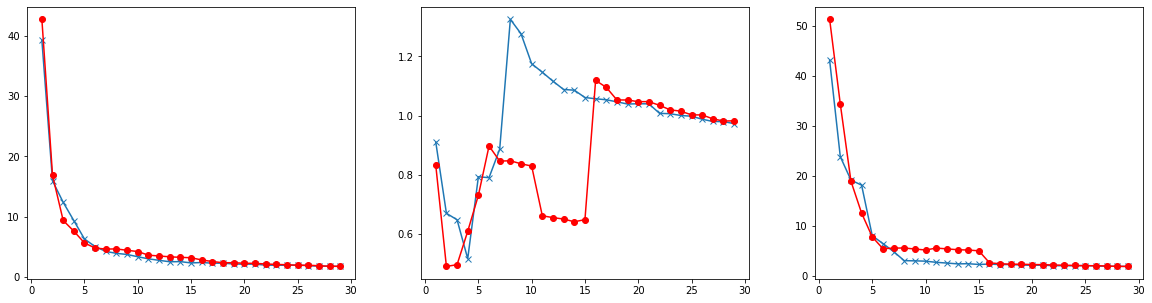

In [101]:
f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,5))
ax1.plot(np.arange(1,30),normalized_clustering_coef_low_risk[1:],'x-',label='low-risk')
ax1.plot(np.arange(1,30),normalized_clustering_coef_high_risk[1:],'ro-',label='high-risk')

ax2.plot(np.arange(1,30),normalized_path_length_low_risk[1:],'x-',label='low-risk')
ax2.plot(np.arange(1,30),normalized_path_length_high_risk[1:],'ro-',label='high-risk')

ax3.plot(np.arange(1,30),small_worldness_low_risk[1:30],'x-',label='low-risk')
ax3.plot(np.arange(1,30),small_worldness_high_risk[1:30],'ro-',label='high-risk')

now I repeat the same thing for random graphs

In [34]:
#here I have 1000 permuted graphs of low and high risk each. For each graph, I will calculate normalized clustering and path length value and small- worldness, using only 10 random graphs for each network sparsity. 2000 x 10 x 30 = 600 000 graphs.
random_low_risk_graphs=MLtraining.load_the_object('./randomized_graph/permutation_statistics/random_low_risk_graphs.pkl')
random_high_risk_graphs=MLtraining.load_the_object('./randomized_graph/permutation_statistics/random_high_risk_graphs.pkl')

In [137]:
C_sparsity_normalized_random_low_risk=np.hstack((MLtraining.load_the_object('./randomized_graph/permutation_statistics/C_sparsity_normalized_random_low_risk0300.pkl'),MLtraining.load_the_object('./randomized_graph/permutation_statistics/C_sparsity_normalized_random_low_risk300600.pkl'),MLtraining.load_the_object('./randomized_graph/permutation_statistics/C_sparsity_normalized_random_low_risk6001000.pkl')))

C_sparsity_normalized_random_high_risk=np.hstack((MLtraining.load_the_object('./randomized_graph/permutation_statistics/C_sparsity_normalized_random_high_risk0300.pkl'),MLtraining.load_the_object('./randomized_graph/permutation_statistics/C_sparsity_normalized_random_high_risk300600.pkl'),MLtraining.load_the_object('./randomized_graph/permutation_statistics/C_sparsity_normalized_random_high_risk6001000.pkl')))

L_sparsity_normalized_random_low_risk=np.hstack((MLtraining.load_the_object('./randomized_graph/permutation_statistics/L_sparsity_normalized_random_low_risk0300.pkl'),MLtraining.load_the_object('./randomized_graph/permutation_statistics/L_sparsity_normalized_random_low_risk300600.pkl'),MLtraining.load_the_object('./randomized_graph/permutation_statistics/L_sparsity_normalized_random_low_risk6001000.pkl')))

L_sparsity_normalized_random_high_risk=np.hstack((MLtraining.load_the_object('./randomized_graph/permutation_statistics/L_sparsity_normalized_random_high_risk0300.pkl'),MLtraining.load_the_object('./randomized_graph/permutation_statistics/L_sparsity_normalized_random_high_risk300600.pkl'),MLtraining.load_the_object('./randomized_graph/permutation_statistics/L_sparsity_normalized_random_high_risk6001000.pkl')))



In [138]:
random_difference={'clustering':{},'path_length':{},'smallworldness':{}}
for i in range(30):
    random_difference['clustering'][i]=np.asarray(C_sparsity_normalized_random_high_risk[i])-np.asarray(C_sparsity_normalized_random_low_risk[i])
    random_difference['path_length'][i]=np.asarray(L_sparsity_normalized_random_high_risk[i])-np.asarray(L_sparsity_normalized_random_low_risk[i])
    random_difference['smallworldness'][i]=(np.asarray(C_sparsity_normalized_random_high_risk[i])/np.asarray(L_sparsity_normalized_random_high_risk[i]))-(np.asarray(C_sparsity_normalized_random_low_risk[i])/np.asarray(L_sparsity_normalized_random_low_risk[i]))

In [139]:
p_values_clustering=[]
for n in range(30):
    observed_group_diff=abs(normalized_clustering_coef_high_risk[n]-normalized_clustering_coef_low_risk[n])
    random_group_diff=abs(random_difference['clustering'][n])
    temp_p_value=len(np.where(random_group_diff>=observed_group_diff)[0])/600
    p_values_clustering.append(temp_p_value)

p_values_path_length=[]
for n in range(30):
    observed_group_diff=abs(normalized_path_length_high_risk[n]-normalized_path_length_low_risk[n])
    random_group_diff=abs(random_difference['path_length'][n])
    temp_p_value=len(np.where(random_group_diff>=observed_group_diff)[0])/600
    p_values_path_length.append(temp_p_value)

p_values_small_worldness=[]
for n in range(30):
    observed_group_diff=abs(small_worldness_high_risk[n]-small_worldness_low_risk[n])
    random_group_diff=abs(random_difference['smallworldness'][n])
    temp_p_value=len(np.where(random_group_diff>=observed_group_diff)[0])/600
    p_values_small_worldness.append(temp_p_value)

significant_indices_clustering=[idx for idx,i in enumerate(p_values_clustering) if i <=0.025]
significant_indices_path_length=[idx for idx,i in enumerate(p_values_path_length) if i <=0.025]
significant_indices_small_worldness=[idx for idx,i in enumerate(p_values_small_worldness) if i <=0.025]
significant_indices_small_worldness.pop(0)

0

Text(0.5, 0, 'network sparsity (%)')

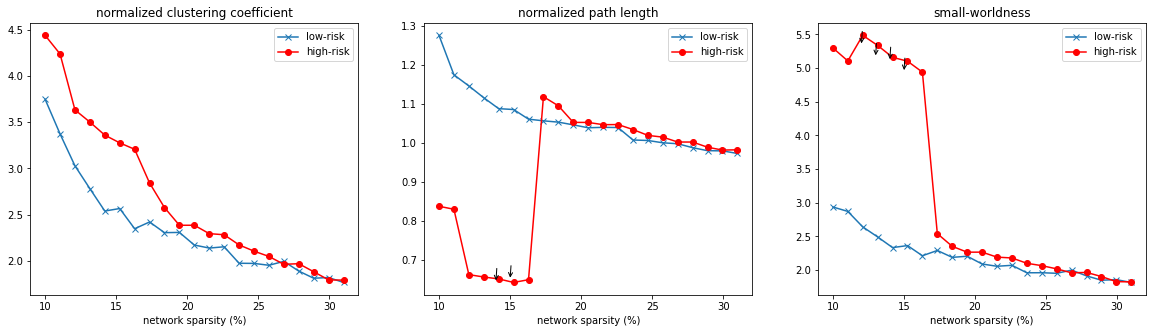

In [140]:
f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,5))
ax1.plot(np.linspace(10,31,21),normalized_clustering_coef_low_risk[9:],'x-',label='low-risk')
ax1.plot(np.linspace(10,31,21),normalized_clustering_coef_high_risk[9:],'ro-',label='high-risk')
# for idx in significant_indices_clustering:
#     ax1.annotate(' ',xy=(idx,normalized_clustering_coef_high_risk[idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
ax1.legend(loc='bottom right')
ax1.set_title('normalized clustering coefficient')
# ax1.set_ylabel('normalized clustering coefficient',fontsize=18)
ax1.set_xlabel('network sparsity (%)')

ax2.plot(np.linspace(10,31,21),normalized_path_length_low_risk[9:],'x-',label='low-risk')
ax2.plot(np.linspace(10,31,21),normalized_path_length_high_risk[9:],'ro-',label='high-risk')
for idx in significant_indices_path_length:
    ax2.annotate(' ',xy=(idx,normalized_path_length_high_risk[idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
ax2.legend(loc='bottom right')
ax2.set_title('normalized path length')
ax2.set_xlabel('network sparsity (%)')

ax3.plot(np.linspace(10,31,21),small_worldness_low_risk[9:],'x-',label='low-risk')
ax3.plot(np.linspace(10,31,21),small_worldness_high_risk[9:],'ro-',label='high-risk')
for idx in significant_indices_small_worldness:
    ax3.annotate(' ',xy=(idx,small_worldness_high_risk[idx]),xytext=(0,20),textcoords='offset pixels',arrowprops=dict(arrowstyle='->'))
ax3.legend(loc='bottom right')
ax3.set_title('small-worldness')
ax3.set_xlabel('network sparsity (%)')